# Topics extraction and sentiment analysis of Tesla in social media
### Libraries

In [1]:

import contractions
import emoji
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import spacy
import text2emotion as te
import tweepy
import warnings
from bertopic import BERTopic
from wordcloud import WordCloud, ImageColorGenerator



!python -m spacy download en_core_web_md 
warnings.filterwarnings("ignore")

/home/cherra/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/cherra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cherra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cherra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### Script variables

In [2]:
DATASET_NAME = 'Tesla'
DATASET_PATH = '../data/{}_tweets.json'.format(DATASET_NAME)
DATASET_OUTPUT_PATH = '../data/{}_tweets_preprocessed.json'.format(DATASET_NAME)
WORDS_TO_SEARCH = ['Tesla', 'tesla']
STOPWORDS = list(nltk.corpus.stopwords.words('english'))

API_GET_TWEETS = False

## Get Twitter data
### Create API Connection

In [3]:
if API_GET_TWEETS:
    # INSERT YOUR CREDENTIALS
    CONSUMER_KEY = ''
    CONSUMER_SECRET = ''
    ACCESS_TOKEN = ''
    ACCESS_SECRET = ''

    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    api = tweepy.API(auth)

### Get tweets
Using the tweepy.Cursor we can get more tweets than with the api.search_tweets method alone. Here we are getting 5000 tweets about Tesla that will be analyzed in next steps

In [4]:
if API_GET_TWEETS:
    tweets = []

    for status in tweepy.Cursor(api.search_tweets, WORDS_TO_SEARCH, lang="en", count=100).items(5000):
        tweets.append(status)

    print('Number of tweets:', len(tweets))
    print(tweets[0])

### Save tweets
Let's save the tweets before working with the to replacate the process in the future

In [5]:
if API_GET_TWEETS:
    tweets_serializables  = [tweet._json for tweet in tweets]

    with open(DATASET_PATH, 'w') as file:
        file.write(json.dumps(tweets_serializables, indent=4))

### Load tweets to Pandas dataframe

In [6]:
tweets_df = pd.read_json(DATASET_PATH)
print('Length tweets:', len(tweets_df))
tweets_df.head()

Length tweets: 5000


,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,2022-09-20 12:55:54+00:00,1572207924252123139,1572207924252123136,RT @KelvinYang7: CATL shipped 11GWh of batteri...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,9,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,2022-09-20 12:55:51+00:00,1572207912470351872,1572207912470351872,RT @StockMKTNewz: Tesla $TSLA today was grante...,False,"{'hashtags': [], 'symbols': [{'text': 'TSLA', ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,7,0,False,False,en,NaN,NaN,NaN,NaN,NaN
2,2022-09-20 12:55:44+00:00,1572207883512840192,1572207883512840192,RT @WholeMarsBlog: Tesla Full Self-Driving Bet...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,21,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,2022-09-20 12:55:44+00:00,1572207883261018114,1572207883261018112,@ValueAnalyst1 @WinterFell_03 @Tesla @elonmusk...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.572204e+18,1.572204e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,2022-09-20 12:55:28+00:00,1572207817402028034,1572207817402028032,@allenbaylus @serialhobbyist1 @GuyDealership O...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.571892e+18,1.571892e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN


### Feature selection
In this notebook we will work exclusively with the text of the tweets but we will also keep the id in case we need to know more about a specific tweet in the future.

In [7]:
tweets_df = tweets_df[['id', 'text']]
tweets_df.head()

,id,text
0,1572207924252123139,RT @KelvinYang7: CATL shipped 11GWh of batteri...
1,1572207912470351872,RT @StockMKTNewz: Tesla $TSLA today was grante...
2,1572207883512840192,RT @WholeMarsBlog: Tesla Full Self-Driving Bet...
3,1572207883261018114,@ValueAnalyst1 @WinterFell_03 @Tesla @elonmusk...
4,1572207817402028034,@allenbaylus @serialhobbyist1 @GuyDealership O...


### Preprocessing
Tweets are freely formatted, they can have pictures, emojis, urls... so we are removing them to improve the topic extraction

In [8]:


nltk.download('words')
words = set(nltk.corpus.words.words())

def give_emoji_free_text(text):
    all_chars = [char for char in text]
    emoji_list = [c for c in all_chars if c in emoji.distinct_emoji_list(text)]
    clean_text = ' '.join([char for char in text.split() if not any(i in char for i in emoji_list)])
    return clean_text

def clean_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = give_emoji_free_text(text)
    text = re.sub('rt', '', text)  # Remove rt
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = re.sub(r'\:|\.', '', text)
    text = " ".join(text.split())
    text = re.sub('(-&gt;|&amp;|&gt|=&gt)', '', text)  # Remove HTML Special entities
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return text


tweets_df['cleaned_text'] = tweets_df.apply(lambda tweet: clean_text(tweet.text), axis=1)
tweets_df.head()

[nltk_data] Downloading package words to /home/cherra/nltk_data...
[nltk_data]   Package words is already up-to-date!


,id,text,cleaned_text
0,1572207924252123139,RT @KelvinYang7: CATL shipped 11GWh of batteri...,catl shipped 11gwh of batteries in august 18 o...
1,1572207912470351872,RT @StockMKTNewz: Tesla $TSLA today was grante...,tesla tsla today was granted 2 patents for 1 h...
2,1572207883512840192,RT @WholeMarsBlog: Tesla Full Self-Driving Bet...,tesla full selfdriving beta 106922 drives from...
3,1572207883261018114,@ValueAnalyst1 @WinterFell_03 @Tesla @elonmusk...,it might be simple and realistic algorithms fo...
4,1572207817402028034,@allenbaylus @serialhobbyist1 @GuyDealership O...,one of my field guys in because has the low en...


### General view

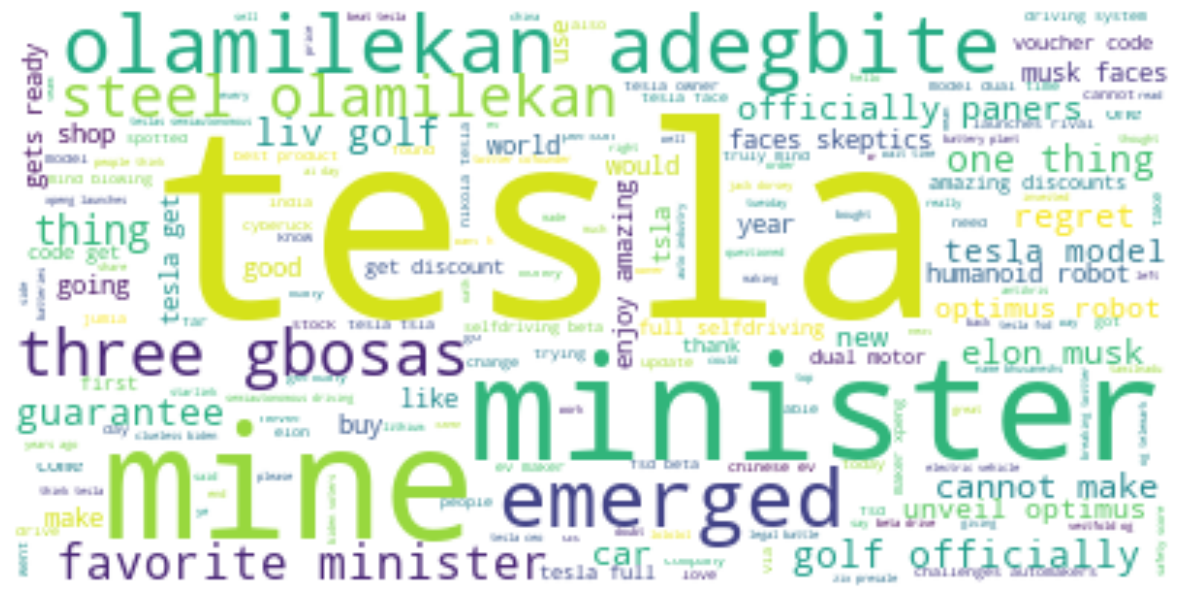

In [9]:

text = " ".join(i for i in tweets_df.cleaned_text)

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Topic extraction (BERT)
We are using BERT with a nlm embedded model to analyze the tweets and get the topics.

In [10]:
tweets_texts = tweets_df['cleaned_text'].tolist()

nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

topic_model = BERTopic(embedding_model=nlp)
topics, probs = topic_model.fit_transform(tweets_texts)

fig = topic_model.visualize_topics()
fig.show()

BERT tries to get all the topics from the texts but if we want a number of topics we can reduce them by merging and excluding not secured topics. 

In [11]:
N_TOPICS = 6

topic_model.reduce_topics(tweets_texts, nr_topics=N_TOPICS)
new_topics = topic_model.topics_
new_probs = topic_model.probabilities_
fig = topic_model.visualize_topics()
fig.show()

In [12]:
tweets_df['bert_topic'] = new_topics
tweets_df.head()

,id,text,cleaned_text,bert_topic
0,1572207924252123139,RT @KelvinYang7: CATL shipped 11GWh of batteri...,catl shipped 11gwh of batteries in august 18 o...,-1
1,1572207912470351872,RT @StockMKTNewz: Tesla $TSLA today was grante...,tesla tsla today was granted 2 patents for 1 h...,-1
2,1572207883512840192,RT @WholeMarsBlog: Tesla Full Self-Driving Bet...,tesla full selfdriving beta 106922 drives from...,2
3,1572207883261018114,@ValueAnalyst1 @WinterFell_03 @Tesla @elonmusk...,it might be simple and realistic algorithms fo...,-1
4,1572207817402028034,@allenbaylus @serialhobbyist1 @GuyDealership O...,one of my field guys in because has the low en...,-1


One feature of BERT is that it can say that a tweet doesn't belong to any topic. As you can see, there are a lot of tweets out of the main topics.

<AxesSubplot:title={'center':'Bert'}>

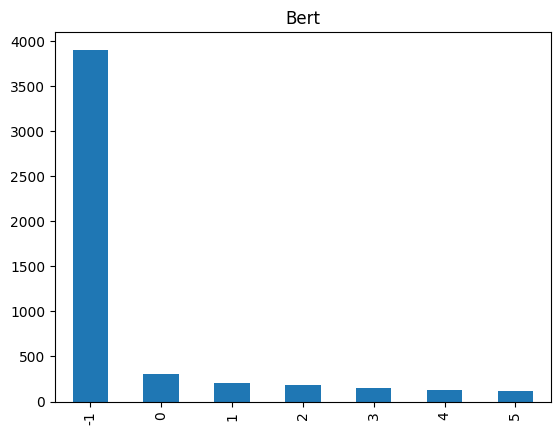

In [13]:
tweets_df['bert_topic'].value_counts().plot(kind='bar', title='Bert')

### Topic visualization
Let's represent in a simple way the different topics extracted from the text

In [14]:
def plot_topic_wordclouds(tweets, n_topics, topic_type='bert_topic'):
    fig, axs = plt.subplots(int(n_topics/2) , 2, figsize=(20, 20))
    for topic in range(n_topics):
        topic_tweets = tweets[tweets[topic_type] == topic]
        text = " ".join(i for i in topic_tweets.cleaned_text)
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=30).generate(text)
        axs[int(topic / 2), topic % 2].imshow(wordcloud)
        axs[int(topic / 2), topic % 2].set_title('Topic {}'.format(topic))
        axs[int(topic / 2), topic % 2].axis('off')
    plt.show()

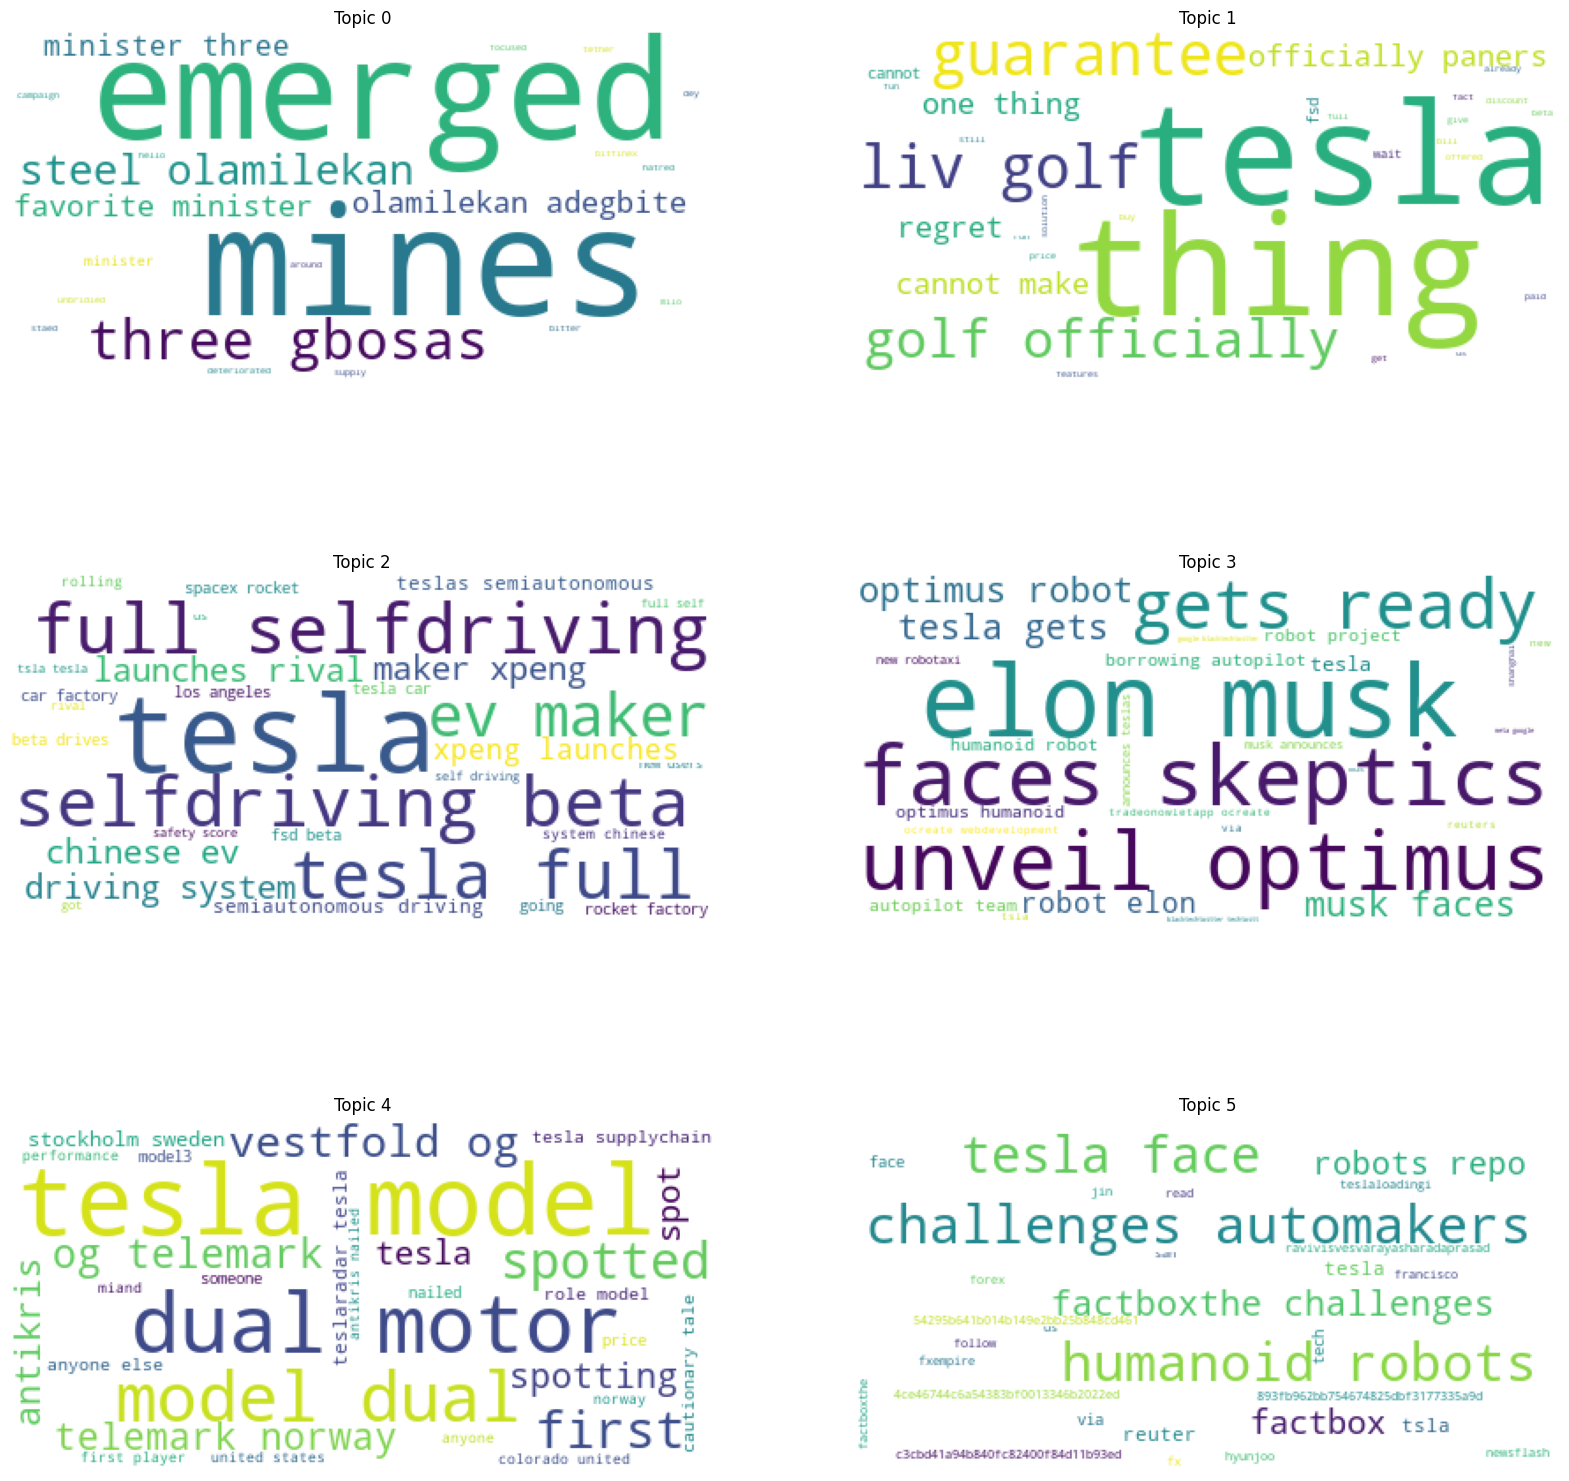

In [15]:
plot_topic_wordclouds(tweets_df, N_TOPICS)

If you are familiar with Tesla news, you will probably know what we are talking about, if not, don't worry, we will explain it below.
- **Topic 0**: As we can see **Olamilekan Adegbite**, who is the Nigerian minister of Mines and Steel Development, has declined to Tesla a license to mine lithium in Nigeria.

![Topic 0 Nigerian minister](../images/topic_0.png "Topic 0")

- **Topic 1**: Saifedean Ammous, who is a famous economist and writter, has called the Tesla's cars "golf cart", it is being answered in many others tweets and it's trendy at the moment.
![Topic 1 Saifedean Ammous](../images/topic_1.png "Topic 1")

- **Topic 2**: Tesla cybertruck **full self driving** from Los Angeles to California. 

![Topic 3 Full self driving](../images/topic_3.png "Topic 3")

- **Topic 3**: Elon Musk's company, Tesla is ready to unvein an **'Optimus' robot**.


![Topic 2 Optimus robot](../images/topic_2.png "Topic 2")


- **Topic 4**: **Bot** that post every Tesla spotted in the world


![Topic 4 Bot spot](../images/topic_4_1.png "Topic 4")


- **Topic 5**: Tesla now challenge the other companies that struggled to create commercially viable human-like robots

![Topic 5 Tesla challenger](../images/topic_5_1.png "Topic 5")

Now that we know a little more about Tesla's current affairs. Let's see how people feel about the different topics.

## Get emotions
For getting the emotions we are using **text2emotion**, this library has a big amount of vocabulary related to differente emotions (Happy, Angry, Surprise, Sad and Fear). The get_emotion method receive a text and give it a score for each sentiment, for getting the total amount of a sentiment we are adding the score of each tweet and getting the total.

In [16]:

nltk.download('omw-1.4')

def get_emotions_row(tweet):
    emotions = te.get_emotion(tweet.cleaned_text)
    return pd.Series([emotions['Happy'], emotions['Angry'], emotions['Surprise'], emotions['Sad'], emotions['Fear']])

get_emotions_lambda = lambda x: get_emotions_row(x)

tweets_df[['happy', 'angry', 'surprise', 'sad', 'fear']] = tweets_df.apply(get_emotions_lambda, axis=1)
tweets_df.head()

[nltk_data] Downloading package omw-1.4 to /home/cherra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,id,text,cleaned_text,bert_topic,happy,angry,surprise,sad,fear
0,1572207924252123139,RT @KelvinYang7: CATL shipped 11GWh of batteri...,catl shipped 11gwh of batteries in august 18 o...,-1,0.0,0.0,0.0,0.00,0.00
1,1572207912470351872,RT @StockMKTNewz: Tesla $TSLA today was grante...,tesla tsla today was granted 2 patents for 1 h...,-1,0.0,0.0,0.0,0.50,0.50
2,1572207883512840192,RT @WholeMarsBlog: Tesla Full Self-Driving Bet...,tesla full selfdriving beta 106922 drives from...,2,0.0,0.0,0.0,0.00,1.00
3,1572207883261018114,@ValueAnalyst1 @WinterFell_03 @Tesla @elonmusk...,it might be simple and realistic algorithms fo...,-1,0.0,0.0,0.0,0.00,1.00
4,1572207817402028034,@allenbaylus @serialhobbyist1 @GuyDealership O...,one of my field guys in because has the low en...,-1,0.0,0.0,0.0,0.33,0.67


### Global sentiment
Here we have a global view of feelings, most of them are negative (Fear, Sad, Angry...) let's see what causes it.

<AxesSubplot:>

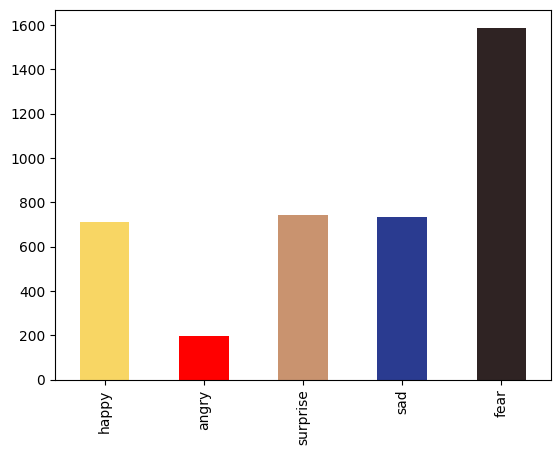

In [17]:
tweets_df[['happy', 'angry', 'surprise', 'sad', 'fear']].sum().plot.bar(color=['#f8d664', '#FF0000', '#c9936f', '#2a3b90', '#2f2323'])

### Topic-Emotions
We want to view the sentiments related to each topic to know them deeper. Maybe we can have some conclusions of this.

In [18]:
def plot_topic_wordcloud_with_emotions(tweets, n_topics, topic_type='bert_topic'):
    fig = plt.figure(figsize=(20, 40))
    fig.suptitle('Topics wordcloud & sentiment')
    subfigs = fig.subfigures(nrows=n_topics, ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'Topic: {row}')
        topic_tweets = tweets[tweets[topic_type] == row]
        axs = subfig.subplots(nrows=1, ncols=2)
        text = " ".join(i for i in topic_tweets.cleaned_text)
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=30).generate(text)
        axs[0].imshow(wordcloud)
        axs[0].axis('off')
        emotions = topic_tweets[['happy', 'angry', 'surprise', 'sad', 'fear']].sum().plot.bar(ax=axs[1], color=['#f8d664', '#FF0000', '#c9936f', '#2a3b90', '#2f2323'])
    plt.show()

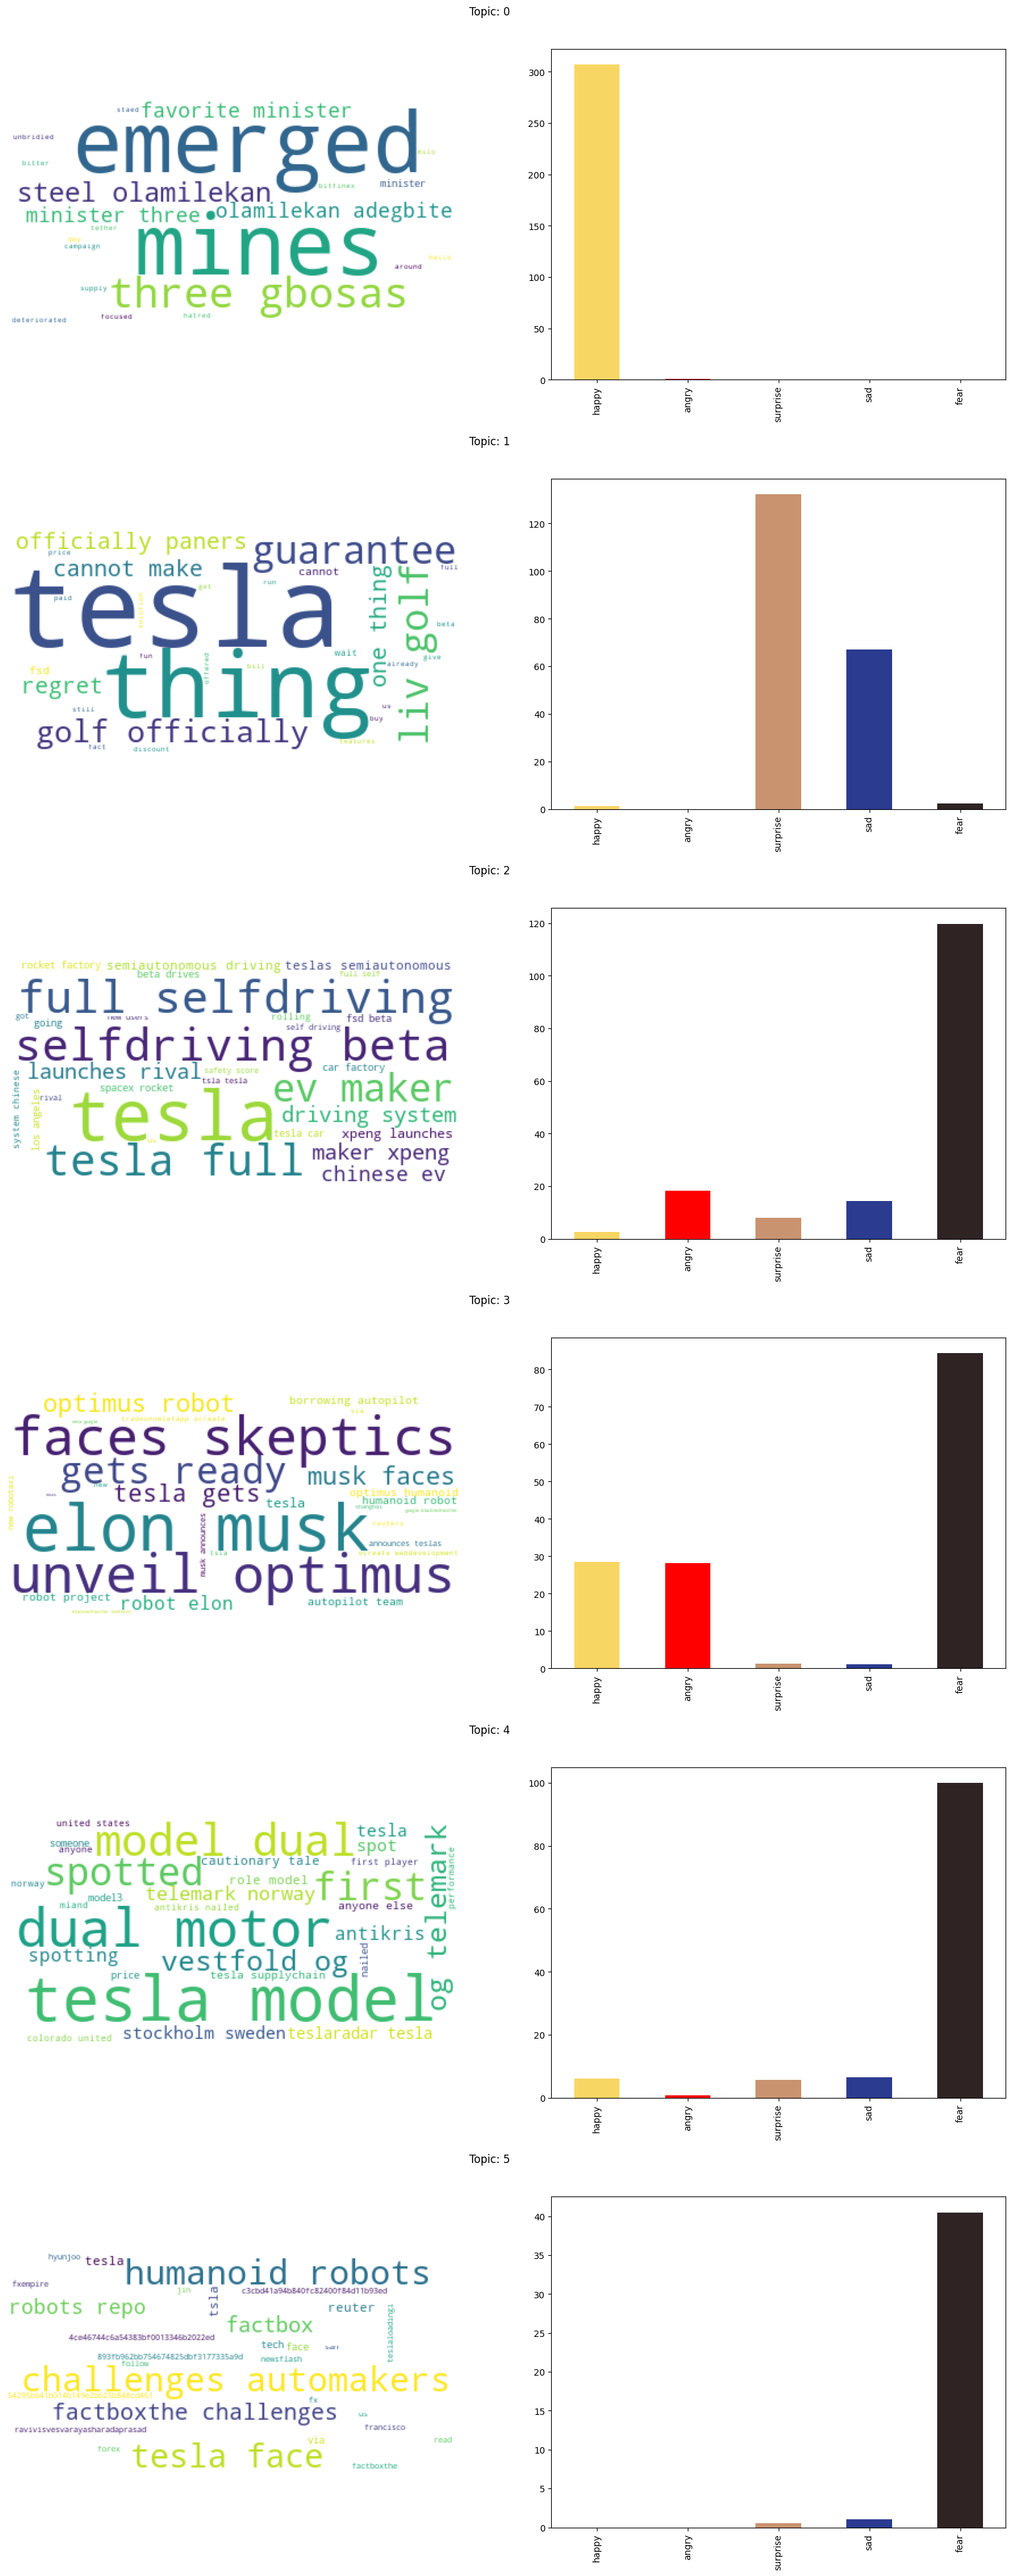

In [19]:
plot_topic_wordcloud_with_emotions(tweets_df, N_TOPICS)

The different topics have different opinions, let's analyze them:
- **Topic 0**: Most tweets are happy, there is a very few amount of angry tweets. Probably, the tweets are written by people who are very happy to see that their country does the things well. They don't want to be exploted as always.
- **Topic 1**: people are surprised, sad and afraid. Maybe it is because they didn't expect that tweet from the economist, which doesn't speak very well of Tesla.
- **Topic 2**: there is a divergence of opinions. There is who are afraid of self driving cars, who is sad because cars sensations are dying, who is angry of a car alone in the road and who is surprised and happy by the achivement. But I think that most people are afraid of letting their car driving them alone.
- **Topic 3**: in this topic there are two types of people. People who are happy to see the revolutionary tech and people who are afraid of such advances.
- **Topic 4**: it is a bot it doesn't have emotions.
- **Topic 5**: most tweets express fear, it may be fear of the challenger.

### Save final dataset

In [20]:
tweets_df.to_csv(DATASET_OUTPUT_PATH, index=False, sep='|')